In [42]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from pandas import DataFrame
from scipy import stats
import matplotlib.font_manager
import sweetviz as sv
import ppscore as pps
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.knn import KNN
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF

In [43]:
os.chdir("W:/DCTC/Random Forest/Python/2020.07.06 HVL Exploration")

data = pd.read_excel('2020.07.06 WellHeaderData.xlsx')
data = data[data['DI 12 Month CUM'].notna()]
data = data[data['LL'].notna()]
basedata = pd.read_excel('2020.07.06 WellHeaderData.xlsx')
basedata = basedata[basedata['LL'].notna()]

cor = data.corr(method ='pearson')
cor_target = abs(cor["DI 12 Month CUM"])

relevant_features = cor_target[cor_target>0.0]

feature_list = pd.DataFrame({'Feature':relevant_features.index, 'Correlation':relevant_features.values})
feature_list = feature_list.sort_values('Correlation')
feature_list.set_index("Feature", inplace=True)
print(feature_list)

#data = data[data["DI STATUS"] == "ACTIVE"]
#data = data[data["RCB Notes"] == "OK"]
#data = data.drop(['LINE', 'SOURCE', 'Last Updated', 'Op vs NonOp', 'NUMBER', 'API12', 'API', 'RESCAT', 'NAME'], axis = 1)
#data = data.drop(['FIELD', 'COUNTY', 'ST', 'OPERATOR', 'RESERVOIR', 'NWC'], axis = 1)
# Remove predetermined outliers
#data = data[(data['PROPPANT (LBS/FT)'] > 500) & (data['PROPPANT (LBS/FT)'] < 5000)]

# Display top of dataframe
#data.head()
#print(data[["RANDOM","GAS EUR (MCF)"]].corr())

                              Correlation
Feature                                  
RANDOM                           0.001102
PetraMidY                        0.001391
SH Latitude                      0.021192
BH Latitude                      0.021890
OGIP (4% Phi Cutoff)             0.025254
2017 NWC                         0.051955
OIL EUR (BBL)                    0.065473
2008 NWC                         0.069758
2016 NWC                         0.072015
2011 NWC                         0.074355
RESCAT                           0.080901
2010 NWC                         0.091147
2012 NWC                         0.095465
2013 NWC                         0.108819
2014 NWC                         0.109840
OGIP/GT (4% Phi Cutoff)          0.110518
2009 NWC                         0.110670
TVD                              0.110727
2015 NWC                         0.110943
LINE                             0.138640
ELEVATION (KB)                   0.174703
PetraMidX                        0

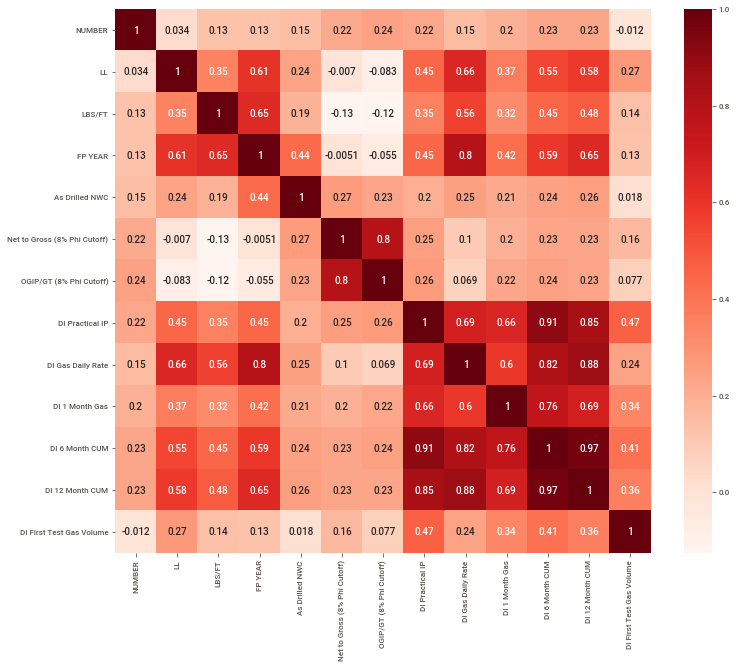

In [44]:
min_cor = feature_list.loc['NUMBER'].values[0]

for index, row in feature_list.iterrows():
    if row['Correlation'] < min_cor:
        feature_list.drop(index,inplace=True)
    if index == "GAS EUR (MCF)":
        feature_list.drop(index,inplace=True)
    if index == "EUR/Ft":
        feature_list.drop(index,inplace=True)

for col in data.columns:
    flag = False
    for index, row in feature_list.iterrows():
        if index in col:
            flag = True
    if flag == False:
        del data[col]    

plt.figure(figsize=(12,10))
cor = data.corr(method ='pearson')
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()


In [45]:
advert_report = sv.analyze(data)

advert_report.show_html('Haynesville.html')


                                   |                         | [  0%]   00:00  -> (? left)
Summarizing dataframe:             |                         | [  0%]   00:00  -> (? left)
:NUMBER:                           |███                  | [ 14%]   00:00  -> (00:00 left)
:NUMBER:                           |████▌                | [ 21%]   00:00  -> (00:01 left)
:LL:                               |████▌                | [ 21%]   00:00  -> (00:01 left)
:LL:                               |██████               | [ 29%]   00:00  -> (00:02 left)
:LBS/FT:                           |██████               | [ 29%]   00:00  -> (00:02 left)
:LBS/FT:                           |███████▌             | [ 36%]   00:01  -> (00:02 left)
:FP YEAR:                          |███████▌             | [ 36%]   00:01  -> (00:02 left)
:FP YEAR:                          |█████████            | [ 43%]   00:01  -> (00:02 left)
:As Drilled NWC:                   |█████████            | [ 43%]   00:01  -> (00:02 left

Creating Associations graph... DONE!


In [46]:
#Predictive Power Score of 0 for Lateral Length
pps.score(basedata,"LL","DI 12 Month CUM")

{'x': 'LL',
 'y': 'DI 12 Month CUM',
 'task': 'regression',
 'ppscore': 0,
 'metric': 'mean absolute error',
 'baseline_score': 948672.2796352584,
 'model_score': 989375.2724059735,
 'model': DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort=False, random_state=None, splitter='best')}

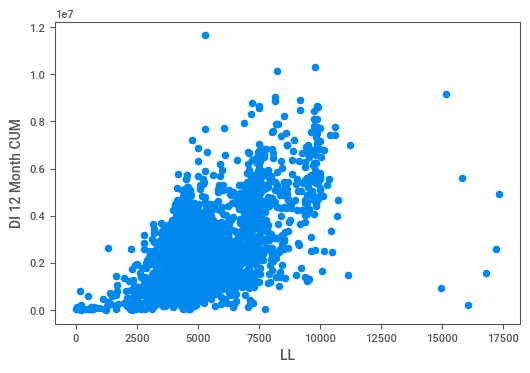

In [48]:
data.plot.scatter('LL','DI 12 Month CUM')

In [49]:
scaler = MinMaxScaler(feature_range=(0, 1))
data[['LL','DI 12 Month CUM']] = scaler.fit_transform(data[['LL','DI 12 Month CUM']])
data[['LL','DI 12 Month CUM']].head()

,LL,DI 12 Month CUM
0,0.233570,0.041775
1,0.242917,0.029635
2,0.175120,0.061421
3,0.231550,0.036306
4,0.211932,0.062968


In [50]:
X1 = data['LL'].values.reshape(-1,1)
X2 = data['DI 12 Month CUM'].values.reshape(-1,1)

X = np.concatenate((X1,X2),axis=1)


In [51]:
random_state = np.random.RandomState(42)
outliers_fraction = 0.05
# Define seven outlier detection tools to be compared
classifiers = {
        'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
        'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
        'Feature Bagging':FeatureBagging(LOF(n_neighbors=35),contamination=outliers_fraction,check_estimator=False,random_state=random_state),
        'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=outliers_fraction),
        'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
        'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
        'Average KNN': KNN(method='mean',contamination=outliers_fraction)
}

OUTLIERS :  208 INLIERS :  4069 Angle-based Outlier Detector (ABOD)


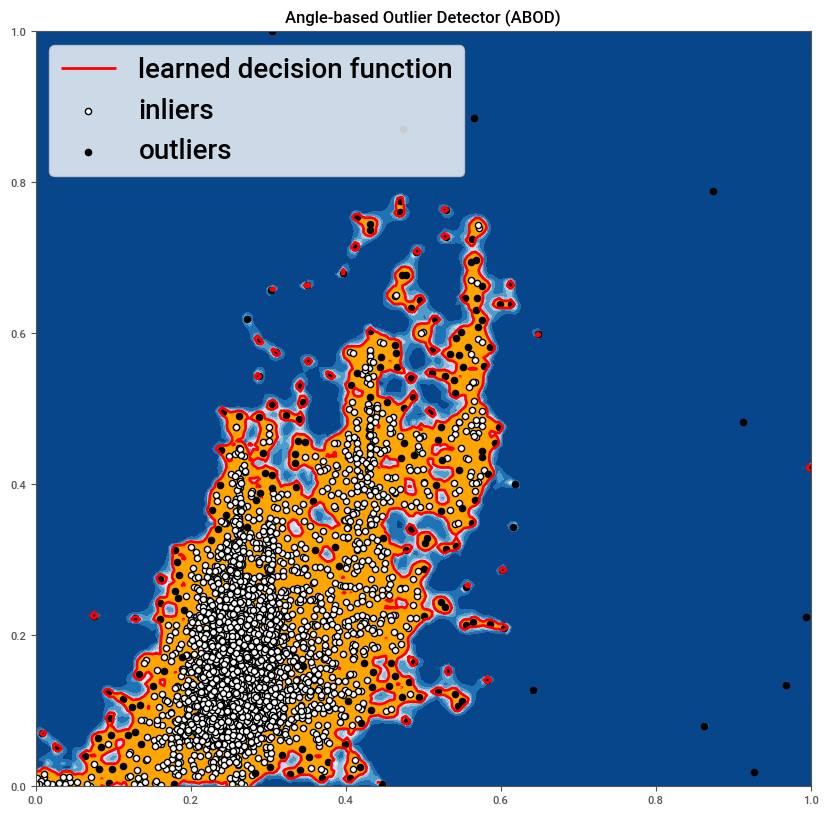

OUTLIERS :  214 INLIERS :  4063 Cluster-based Local Outlier Factor (CBLOF)


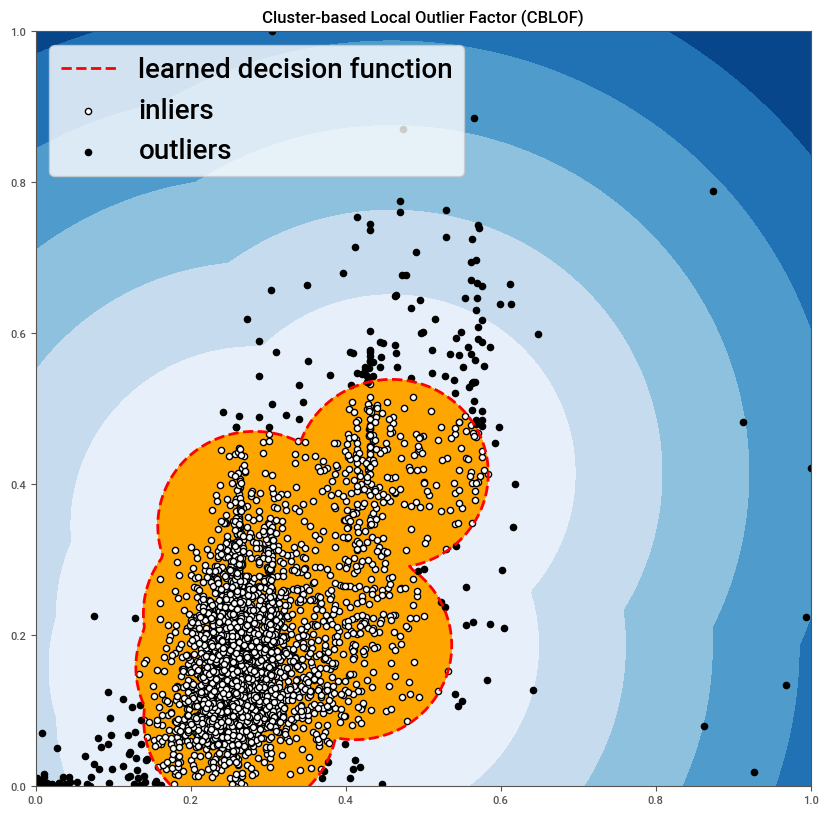

OUTLIERS :  179 INLIERS :  4098 Feature Bagging


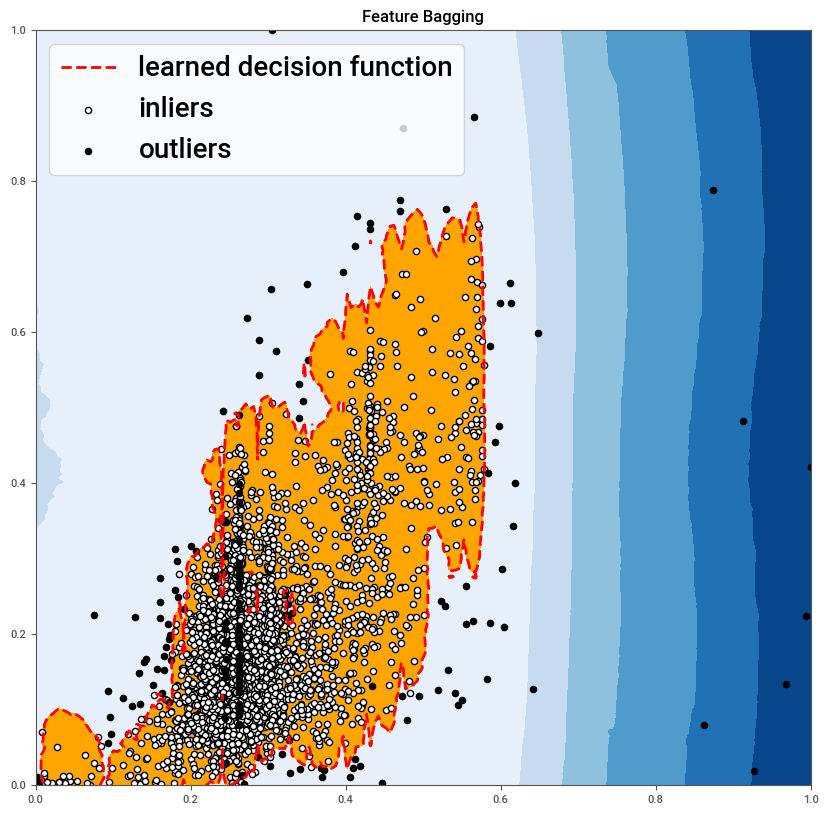

OUTLIERS :  209 INLIERS :  4068 Histogram-base Outlier Detection (HBOS)


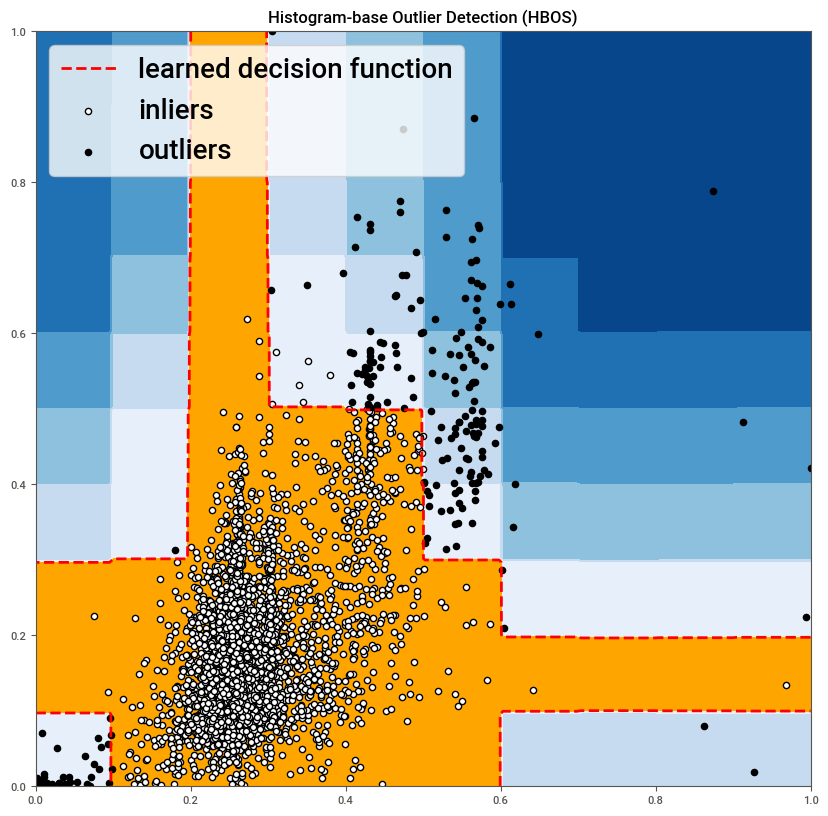

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


OUTLIERS :  214 INLIERS :  4063 Isolation Forest


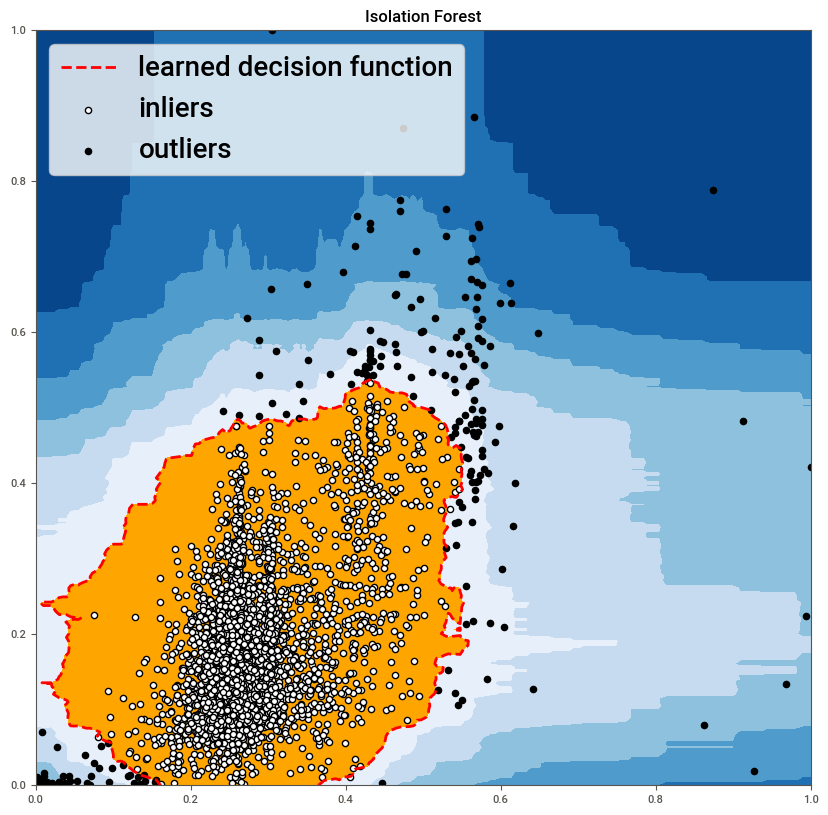

OUTLIERS :  176 INLIERS :  4101 K Nearest Neighbors (KNN)


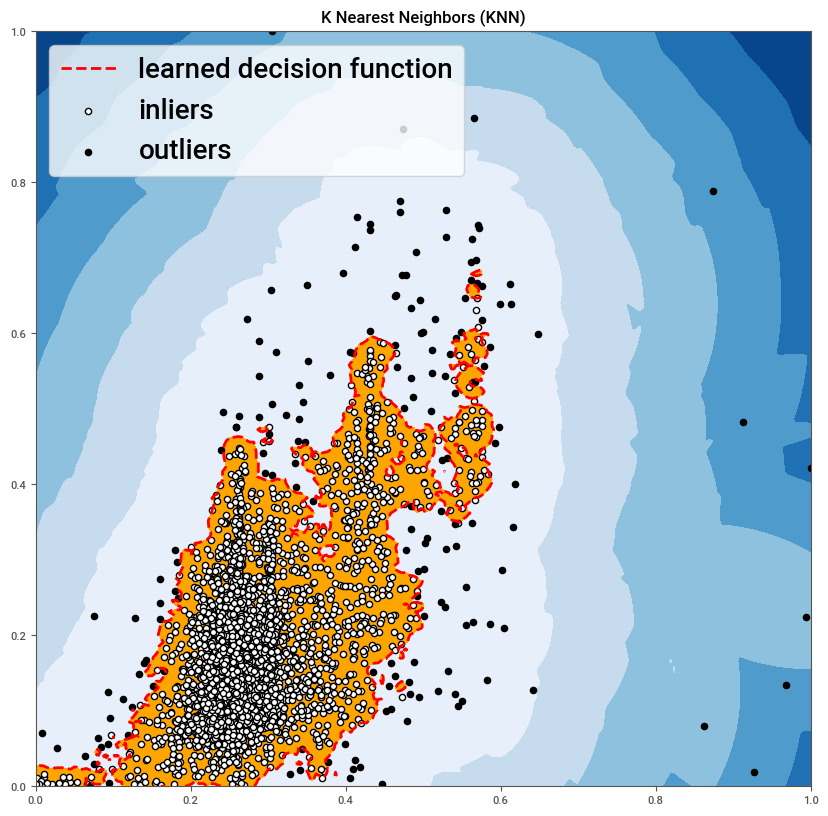

OUTLIERS :  109 INLIERS :  4168 Average KNN


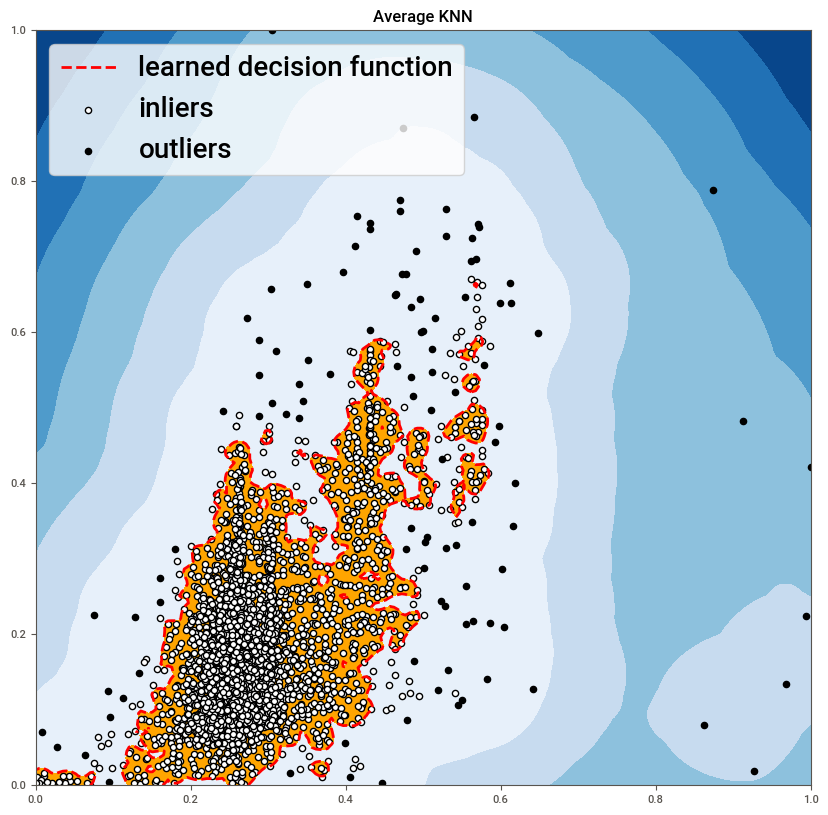

In [54]:
xx , yy = np.meshgrid(np.linspace(0, 1, 200), np.linspace(0, 1, 200))

for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    plt.figure(figsize=(10, 10))
    
    # copy of dataframe
    dfx = data
    dfx['outlier'] = y_pred.tolist()
    
    # IX1 - inlier feature 1,  IX2 - inlier feature 2
    IX1 =  np.array(dfx['LL'][dfx['outlier'] == 0]).reshape(-1,1)
    IX2 =  np.array(dfx['DI 12 Month CUM'][dfx['outlier'] == 0]).reshape(-1,1)
    
    # OX1 - outlier feature 1, OX2 - outlier feature 2
    OX1 =  dfx['LL'][dfx['outlier'] == 1].values.reshape(-1,1)
    OX2 =  dfx['DI 12 Month CUM'][dfx['outlier'] == 1].values.reshape(-1,1)
         
    print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
        
    # threshold value to consider a datapoint inlier or outlier
    threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
        
    # decision function calculates the raw anomaly score for every point
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)
          
    # fill blue map colormap from minimum anomaly score to threshold value
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
    # draw red contour line where anomaly score is equal to thresold
    a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
    # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
    plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
        
    b = plt.scatter(IX1,IX2, c='white',s=20, edgecolor='k')
    
    c = plt.scatter(OX1,OX2, c='black',s=20, edgecolor='k')
       
    plt.axis('tight')  
    
    # loc=2 is used for the top left corner 
    plt.legend(
        [a.collections[0], b,c],
        ['learned decision function', 'inliers','outliers'],
        prop=matplotlib.font_manager.FontProperties(size=20),
        loc=2)
      
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.title(clf_name)
    plt.show()
    